In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)
import warnings
import gc
from tqdm import tqdm
from joblib import Parallel, delayed
from datetime import timedelta, datetime
warnings.filterwarnings('ignore')

txt_feature_path = 'feature/txt/'
feature_path = 'feature/'
model_path = 'model/'
submit_path = 'submit/'
#stacking feature data
metafeature_path = 'meta-feature/'
pic_path = 'pic/'
train_data_1_len = 1000000
train_data_2_len = 5000000
test_data_len = 1000000

def reduce_mem_usage(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = data.memory_usage().sum() / 1024**2    
    for col in data.columns:
        col_type = data[col].dtypes
        if col_type in numerics:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)    
    end_mem = data.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return data

In [ ]:
train_data_1 = pd.read_csv(txt_feature_path+'round1_train.txt','\t')
train_data_2 = pd.read_csv(txt_feature_path+'round2_train.txt','\t')
test_A_data = pd.read_csv(txt_feature_path+'round2_test_A.txt','\t')
test_B_data = pd.read_csv(txt_feature_path+'round2_test_B.txt','\t')
data = pd.concat([train_data_1,train_data_2,test_A_data,test_B_data],axis=0,sort=False).reset_index(drop=True)
del train_data_1,train_data_2,test_A_data,test_B_data
gc.collect()

In [2]:
%time data = pd.read_feather(feature_path+'combine.bin')
%time data = reduce_mem_usage(data)
gc.collect()

Wall time: 3.23 s
Mem. usage decreased to 1037.60 Mb (57.0% reduction)
Wall time: 7.24 s


0

In [3]:
data.dtypes

empty_count             float16
make                      int16
model                     int16
big_model                 int16
model_equal_make           int8
ip                        int32
ip1                       int16
reqrealip                 int32
ip2                       int16
ip3                       int32
reqrealip1                 int8
reqrealip2                int16
reqrealip3                int16
ip_equal                   int8
adidmd5                   int32
imeimd5                   int32
macmd5                    int32
adunitshowid              int16
mediashowid               int16
city                      int16
province                   int8
h                       float16
w                       float32
ppi                     float16
h_w_ratio               float16
screen_area             float32
size                    float16
orientation                int8
creative_dpi              int16
px                      float16
sid                      object
label   

In [4]:
def df_unique_num(df):
    '''
    获得每列特征种类数
    '''
    num = []
    for col in df.columns:
        num.append(len(df[col].unique()))
    return pd.DataFrame(num,index=df.columns,columns=['unique_num']).T

def df_null_num(df):
    nan_num = []
    empty_num = []
    zero_num = []
    col_ratio = []
    num = [nan_num,empty_num,zero_num,col_ratio]
    for col in df.columns:
        nan_num.append(len(df[col][df[col].isnull()]))
        empty_num.append(len(df[col][df[col]=='empty']))
        zero_num.append(len(df[col][(df[col]==0.0)|(df[col]==-1.0)]))
        col_ratio.append(len(df))
    for i in range(len(col_ratio)):
        col_ratio[i] = str((nan_num[i] + empty_num[i] + zero_num[i])/col_ratio[i] * 100) + "%"
    return pd.DataFrame(num,columns=df.columns,index=['nan_num','empty_num','zero_num','col_ratio'])

features = [col for col in data.columns if col not in ['sid','label']]

In [ ]:
ax = train_data[1000000:].label.value_counts().plot.bar()

In [ ]:
train_data[1000000:].label.value_counts()

In [ ]:
train_data[1000000:].label.value_counts()[0]/train_data[1000000:].shape[0]

In [ ]:
data.UID_imeimd5_nunique

In [ ]:
data.UID_macmd5_nunique

In [5]:
%time unique_num_df = df_unique_num(data[features]).T
unique_num_df

Wall time: 6.99 s


,unique_num
empty_count,17
make,2297
model,14434
big_model,10024
model_equal_make,2
ip,4561263
ip1,661
reqrealip,34764
ip2,12452
ip3,414247


In [ ]:
%time unique_num_df = df_unique_num(data[features]).T
unique_num_df

In [ ]:
%time unique_num_df = df_unique_num(data[5000000:6000000][features]).T
unique_num_df

In [ ]:
%time unique_num_df = df_unique_num(data[6000000:][features]).T
unique_num_df

In [ ]:
%time null_num_df = df_null_num(data[features]).T
null_num_df

In [ ]:
ax = data[6000000:].hour.value_counts().plot.bar()

In [ ]:
ax = sns.boxplot(x='dvctype',y='ppi',data=data)

In [ ]:
type(data)

In [40]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i=0
    sns.set_style('whitegrid')
    plt.figure()
    #subplots(子图行数,子图列数,figsize=(20,20))
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    for feature in tqdm(features):
        i += 1
        if data.dtypes[feature] == np.object:
            raise ValueError('Wrong feature type:' + feature)
        #subplots(子图行数,子图列数，第几个子图-索引)
        plt.subplot(1,2,i)
        #hist - 是否显示原始直方图
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        # 轴参数
        plt.tick_params(axis='x', which='major', labelsize=12, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=12)
    #Parallel(n_jobs=2,verbose=10)(delayed(create_gragh)(i,feature) for i,feature in enumerate(features))
    
    plt.show()

#创建标签标准化特征
def create_labelencoder(data,object_cols=None):
    from sklearn import preprocessing
    #返回内容为字符串的列名
    if object_cols == None:
        object_cols = list(data.dtypes[data.dtypes == np.object].index)
    for col in object_cols:
        if col!= 'sid':
            #标签标准化，将object（字符串列）处理
            #例如["paris", "paris", "tokyo", "amsterdam"]；里面不同的标签数目是3个，则标准化标签之后就是0，1，2，并且根据字典排序
            lbl = preprocessing.LabelEncoder()
            #再一次使用transform是因为labelencoder返回的是LabelEncoder对象
            data[col] = lbl.fit_transform(data[col].astype(str))
    print('create labelencoder_feature done')
    return data

In [5]:
t0 = data[:6000000].loc[data['label'] == 0]
t1 = data[:6000000].loc[data['label'] == 1]

In [ ]:
from sklearn import preprocessing
left = 'pkgname&adunitshowid&ver&osv'
right = 'make'
data[left+'&'+right] = data[left].astype(str)+'_with_'+data[right].astype(str)
lbl = preprocessing.LabelEncoder()
data[left+'&'+right] = lbl.fit_transform(data[left+'&'+right].astype(str))
data[left+'&'+right + "_count"] = data.groupby([left+'&'+right])[left+'&'+right].transform('count')

In [ ]:
%time plot_feature_distribution(t0, t1, '0', '1',features)

In [ ]:
data = data[:6000000]

In [ ]:
adunitshowid&city&pkgname
adunitshowid&pkgname
adunitshowid&city&pkgname&make
city&pkgname&make
adunitshowid&pkgname&make
adunitshowid&ver&make
adunitshowid&ver&make&pkgname
adunitshowid&city&make
adunitshowid&make
mediashowid&pkgname&ver
mediashowid&pkgname&ver&hour
mediashowid&pkgname&ver&period
mediashowid&pkgname
mediashowid&ver
make&osv

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


<Figure size 432x288 with 0 Axes>

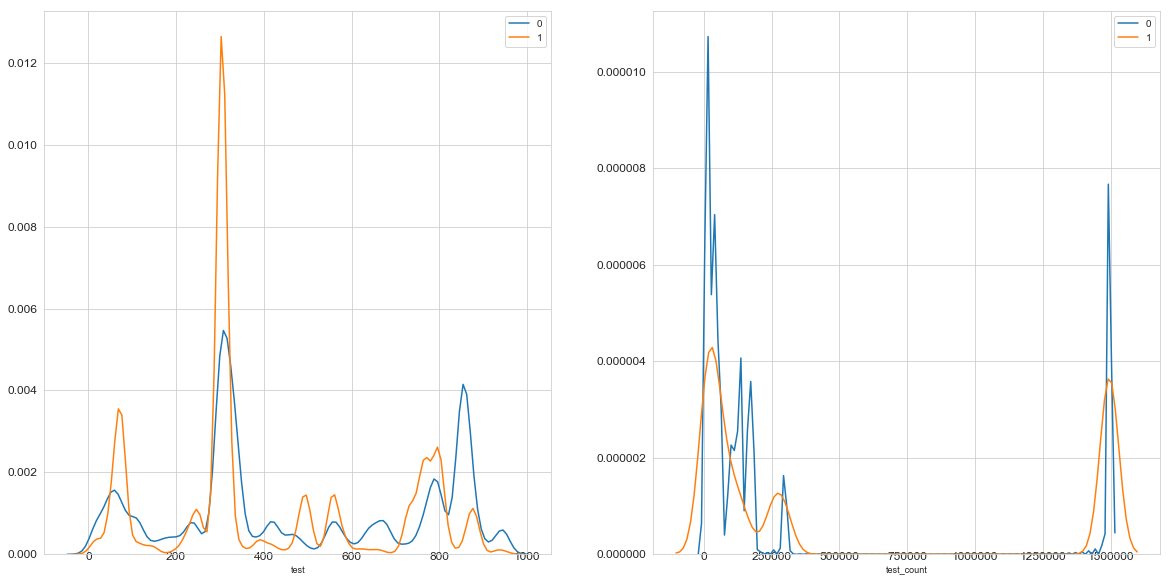

Wall time: 1.64 s


In [59]:
from sklearn import preprocessing
ft = 'test'
data[ft] = data['mediashowid'].astype(str)+'&'+data['adunitshowid'].astype(str)
lbl = preprocessing.LabelEncoder()
data[ft] = lbl.fit_transform(data[ft].astype(str))
data[ft + "_count"] = data.groupby([ft])[ft].transform('count')
t0 = data.loc[data['label'] == 0]
t1 = data.loc[data['label'] == 1]
%time plot_feature_distribution(t0, t1, '0', '1',[ft,ft + "_count"])

In [ ]:
data.drop([left+'&'+right,left+'&'+right + "_count"],axis=1,inplace=True)

In [ ]:
osv&lan,osv&make

In [ ]:
%time data = create_labelencoder(data)

In [ ]:
data['datetime'] = pd.to_datetime(data['nginxtime'] / 1000, unit='s') + timedelta(hours=8)
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour 
data = data.drop(['datetime'],axis=1)

In [ ]:
data['datetime'] = pd.to_datetime(data['nginxtime'] / 1000, unit='s') + timedelta(hours=8)

In [ ]:
data[1000000:]['datetime'].value_counts()

In [ ]:
data[''][data['datetime']=='2019-08-10 14:20:19.756000042']

In [ ]:
features = [col for col in data.columns if col not in ['sid', 'label']]

In [ ]:
col = 'model'
print(len(data[col][data[col].isnull()]))
data[col].value_counts()

In [ ]:
import re
pt1 = re.compile('[0-9]+\.[0-9]+\.[0-9]+')
pt2 = re.compile('[0-9]+\.[0-9]+')
def clean_osv(x):
    result = re.search(pt1,x)
    if result == None:
        result = re.search(pt2,x)
    if result == None:
        x = x.strip('android_')
        return x.strip('android')
    return result.group()
%time data['osv'] = data['osv'].apply(lambda x: str(x).lower()).apply(lambda x: x.replace(',','.')).apply(clean_osv)

In [ ]:
p='安徽'
#data['city'][data['city'].isnull()]='empty'
%time tmp = data[['ip','city']][data['city']==p].groupby(by=['ip'])['city'].agg(lambda x: x.value_counts().index[0]).reset_index().rename(columns={col: 'tmp'})

In [ ]:
nextclick = (data[['adunitshowid','nginxtime']].groupby(['adunitshowid'])['nginxtime'].shift(-1) - data['nginxtime'])

In [ ]:
nextclick[:100]

In [24]:
def cal_intersection_ratio(data,col_name):
    train_value = set(data[:5000000][col_name].values)
    test_a_value = set(data[5000000:6000000][col_name].values)
    test_b_value = set(data[6000000:][col_name].values)
    
    print('intersection of train and test_a in train:',len(train_value&test_a_value)/len(train_value))
    print('intersection of train and test_b in train:',len(train_value&test_b_value)/len(train_value))
    print('intersection of train and test in train:',len(train_value&(test_a_value|test_b_value))/len(train_value))
    print('intersection of train and test in test:',len(train_value&(test_a_value|test_b_value))/len(test_a_value|test_b_value))
    print('intersection of test_a and test_b in test_a:',len(train_value&test_a_value)/len(test_a_value))
    print('intersection of test_a and test_b in test_b:',len(train_value&test_b_value)/len(test_b_value))

In [51]:
cal_intersection_ratio(data,'adunitshowid&reqrealip')

intersection of train and test_a in train: 0.16210359771617253
intersection of train and test_b in train: 0.16114053793767627
intersection of train and test in train: 0.17520808970213936
intersection of train and test in test: 0.5490999245445726
intersection of test_a and test_b in test_a: 0.6868259982512387
intersection of test_a and test_b in test_b: 0.6872524570925627


In [63]:
data[['pkgname&ver','pkgname&ver&apptype&osv&lan']].corr()

,pkgname&ver,pkgname&ver&apptype&osv&lan
pkgname&ver,1.000000,0.998911
pkgname&ver&apptype&osv&lan,0.998911,1.000000
